In [1]:
from imaster_paper_args import *

Start_client: No scheduler file, will start local cluster at  ./temp_skylens/pid340400/


In [2]:
from astropy.io import fits
import os
import numpy as np
import matplotlib.pyplot as plt

import pyccl as ccl
import pymaster as nmt
import healpy as hp

In [3]:
path = os.path.join(os.path.dirname(os.environ['SCRATCH']), 
                    'share/raytracesim/HSC_S16A/mocks_4zbins')

In [4]:
i = 25
rot = 9
sims = [os.path.join(path, sim) for sim in os.listdir(path) if f'r{i:03d}_rot{rot:02d}' in sim]

In [5]:
sim_dict = {}
for i, sim in enumerate(sims):
    # Remove objects with z = -1
    sim = fits.open(sim)[1].data
    sim = sim[sim['z_source_mock'] != -1]

    # Get z centers and boundary
    z = np.unique(sim['z_source_mock'])
    z_edges = 0.5 * (z[1:] + z[:-1])
    z_edges = np.concatenate([[0], z_edges, [np.max(z)+0.2]])
    dNdz, _ = np.histogram(sim['z_source_mock'], bins=z_edges, density=True)
    sim_dict[i] = {
        'z': z,
        'dNdz': dNdz,
        'ra': sim['ra_mock'],
        'dec': sim['dec_mock'],
        'e1': sim['e1_mock'],
        'e2': sim['e2_mock'],
        'g1': sim['shear1_sim'],
        'g2': sim['shear2_sim']
    }
sim_dict['n_bins'] = len(sim_dict.keys())

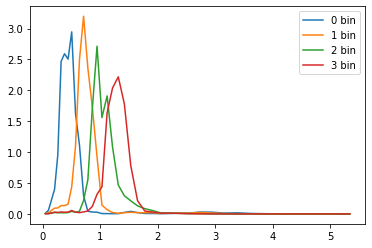

In [6]:
for b in range(sim_dict['n_bins']):
    sim = sim_dict[b]
    plt.plot(sim['z'], sim['dNdz'], label=f'{b} bin')
plt.legend()

In [7]:
nside = 128
npix = hp.nside2npix(nside)
pixels = dict()
for i in range(sim_dict['n_bins']):
    sim = sim_dict[i]
    pixels[i] = hp.ang2pix(nside, sim['ra'], sim['dec'], lonlat=True)

In [8]:
cosmo = ccl.Cosmology(Omega_c=0.233, Omega_b=0.046, h=0.7, n_s=0.97, sigma8=0.82)
ell = np.arange(3 * nside)

In [9]:
tracers = [ccl.WeakLensingTracer(cosmo, (sim_dict[i]['z'], sim_dict[i]['dNdz'])) for i in range(sim_dict['n_bins'])]

In [10]:
cl_ccl = dict()
for i in range(sim_dict['n_bins']):
    for j in range(i, sim_dict['n_bins']):
        cl_ccl[(i, j)] = ccl.cls.angular_cl(cosmo, tracers[i], tracers[j], ell)

In [11]:
cl_ccl.keys()

dict_keys([(0, 0), (0, 1), (0, 2), (0, 3), (1, 1), (1, 2), (1, 3), (2, 2), (2, 3), (3, 3)])

In [12]:
gaussian_maps = dict()
for i in range(sim_dict['n_bins']):
    cl = cl_ccl[(i, i)]
    gaussian_maps[i] = hp.sphtfunc.synfast([
        cl, cl, cl*0, cl, cl*0, cl*0
    ], nside, new=True, pol=True)

In [13]:
gamma1_map = dict()
gamma2_map = dict()
mask = dict()

for i in range(sim_dict['n_bins']):
    sim = sim_dict[i]
    gamma1_map[i] = np.zeros(npix)
    gamma2_map[i] = np.zeros(npix)
    mask[i] = np.zeros(npix)
    
    gamma1_map[i][pixels[i]] += sim['g1']
    gamma2_map[i][pixels[i]] += sim['g2']
    mask[i][pixels[i]] += np.ones_like(sim['g2'])
    
    gamma1_map[i][mask[i] > 0] = np.divide(gamma1_map[i][mask[i] > 0], mask[i][mask[i] > 0])
    gamma2_map[i][mask[i] > 0] = np.divide(gamma2_map[i][mask[i] > 0], mask[i][mask[i] > 0])
    mask[i] = mask[i].astype('bool')

In [14]:
for i in range(sim_dict['n_bins']):
    gaussian_map = gaussian_maps[i]
    m = mask[i]
    gaussian_map[:, ~m] = hp.UNSEEN

In [15]:
def plot_mollview(maps):
    # Assuming overdensity, g1, g2
    for i, m in enumerate(maps):
        cmap = None if i == 0 else 'seismic'
        hp.mollview(m, cmap=cmap)

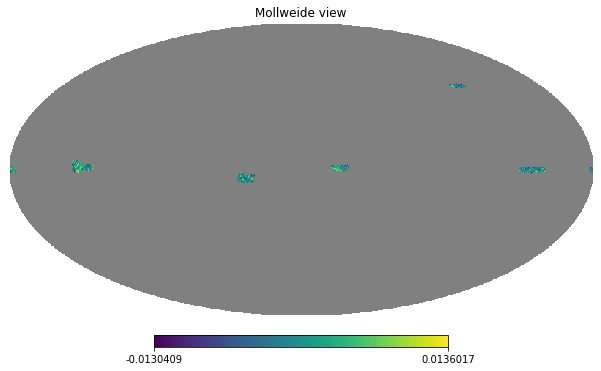

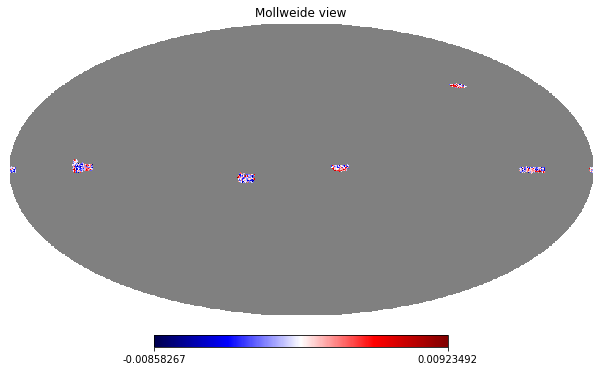

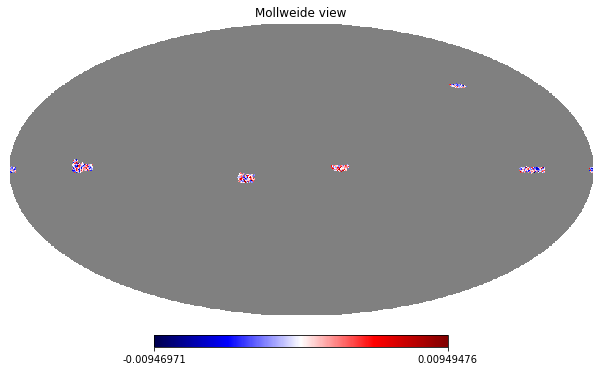

In [16]:
plot_mollview(gaussian_maps[1])

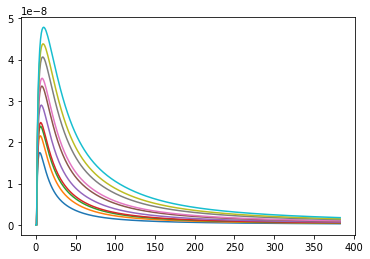

In [17]:
for i in range(sim_dict['n_bins']):
    for j in range(i, sim_dict['n_bins']):
        plt.plot(cl_ccl[(i, j)])

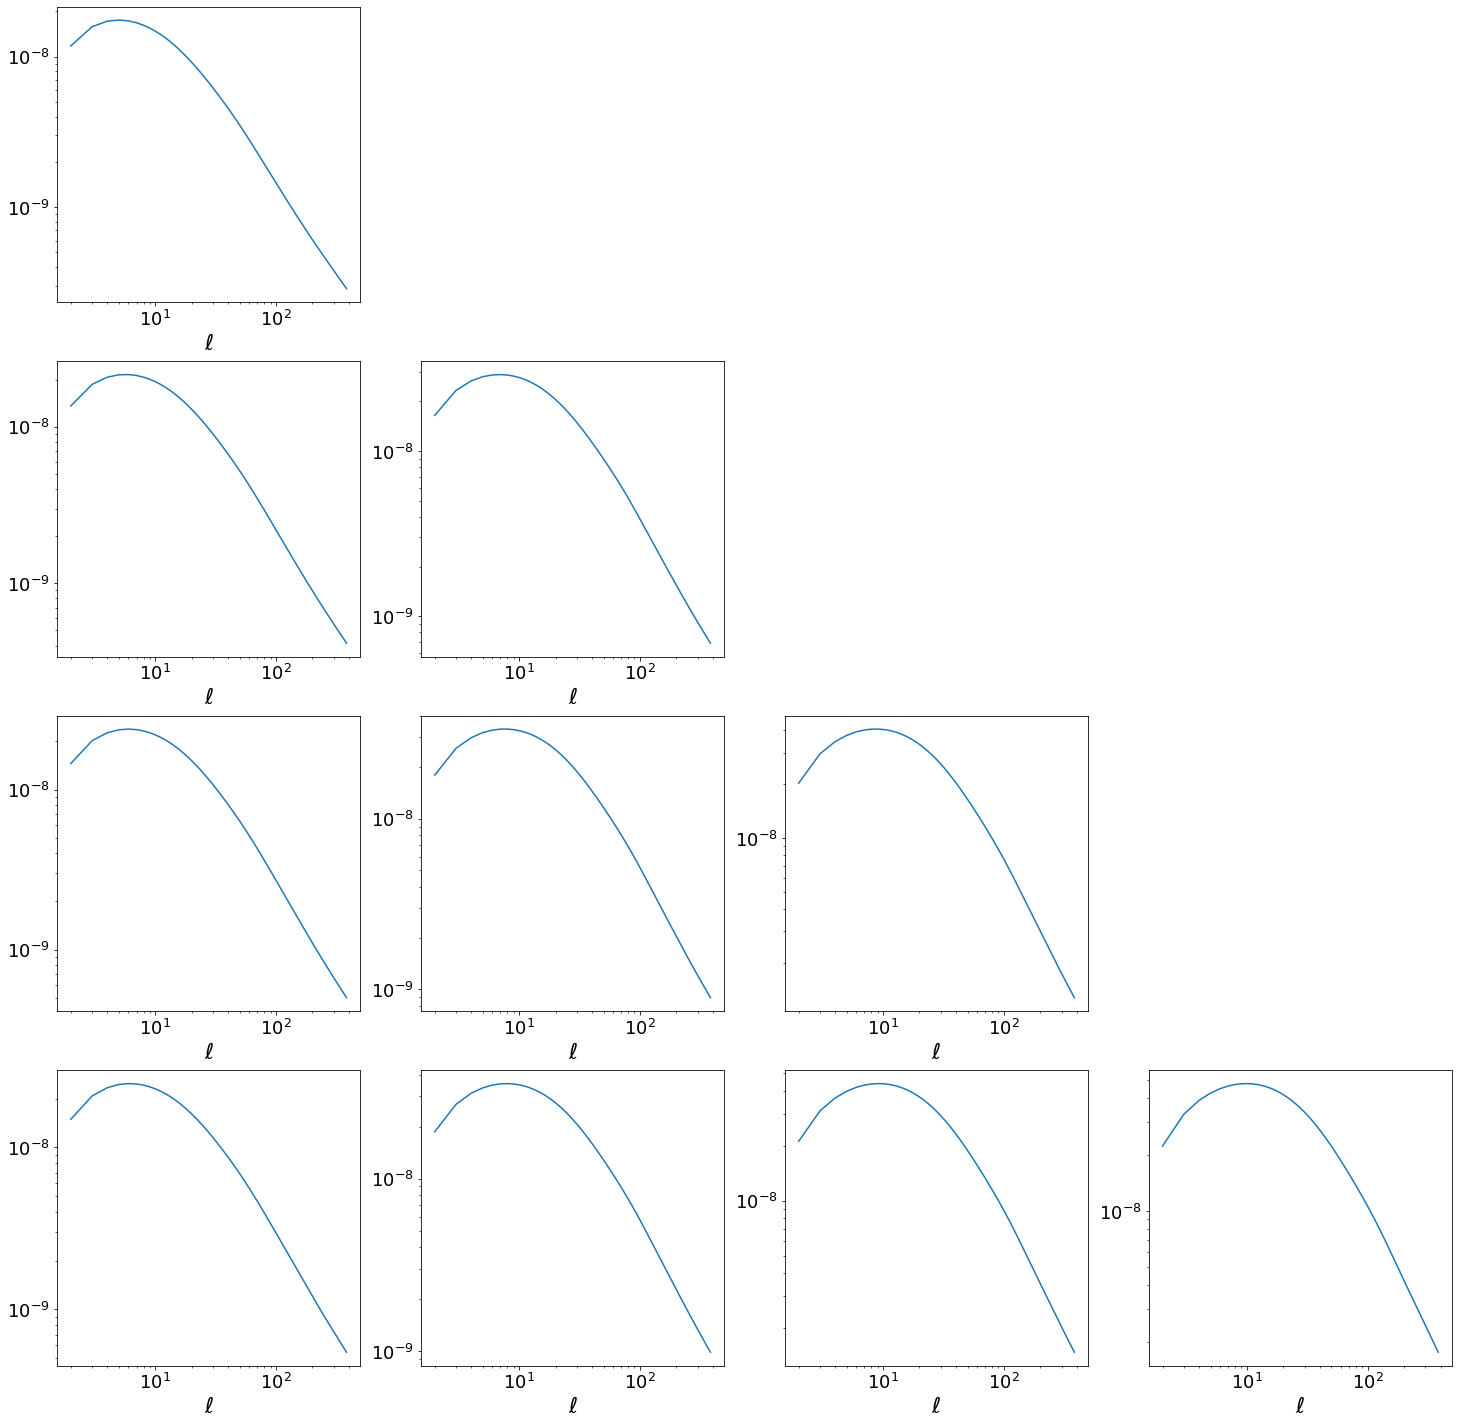

In [18]:
plt.figure(figsize=(25, 25))
n_bins = sim_dict['n_bins']
for i in range(n_bins):
    for j in range(n_bins):
        if j <= i:
            plt.subplot(n_bins, n_bins, i * n_bins + j + 1)
            plt.loglog(ell[2:], cl_ccl[(j, i)][2:])
            plt.xlabel(r'$\ell$', fontsize=22)
            plt.xticks(fontsize=18)
            plt.yticks(fontsize=18)

# NaMaster

In [19]:
Dl_nmt = dict()
for i in range(sim_dict['n_bins']):
    for j in range(i, sim_dict['n_bins']):
        gmi = gaussian_maps[i]
        gmj = gaussian_maps[j]
        f2_i = nmt.NmtField(mask[i], [gmi[1], gmi[2]])
        f2_j = nmt.NmtField(mask[j], [gmj[1], gmj[2]])
        Dl = nmt.compute_coupled_cell(f2_i, f2_j)
        Dl_nmt[(i, j)] = np.abs(Dl[0])
        del f2_i, f2_j, Dl

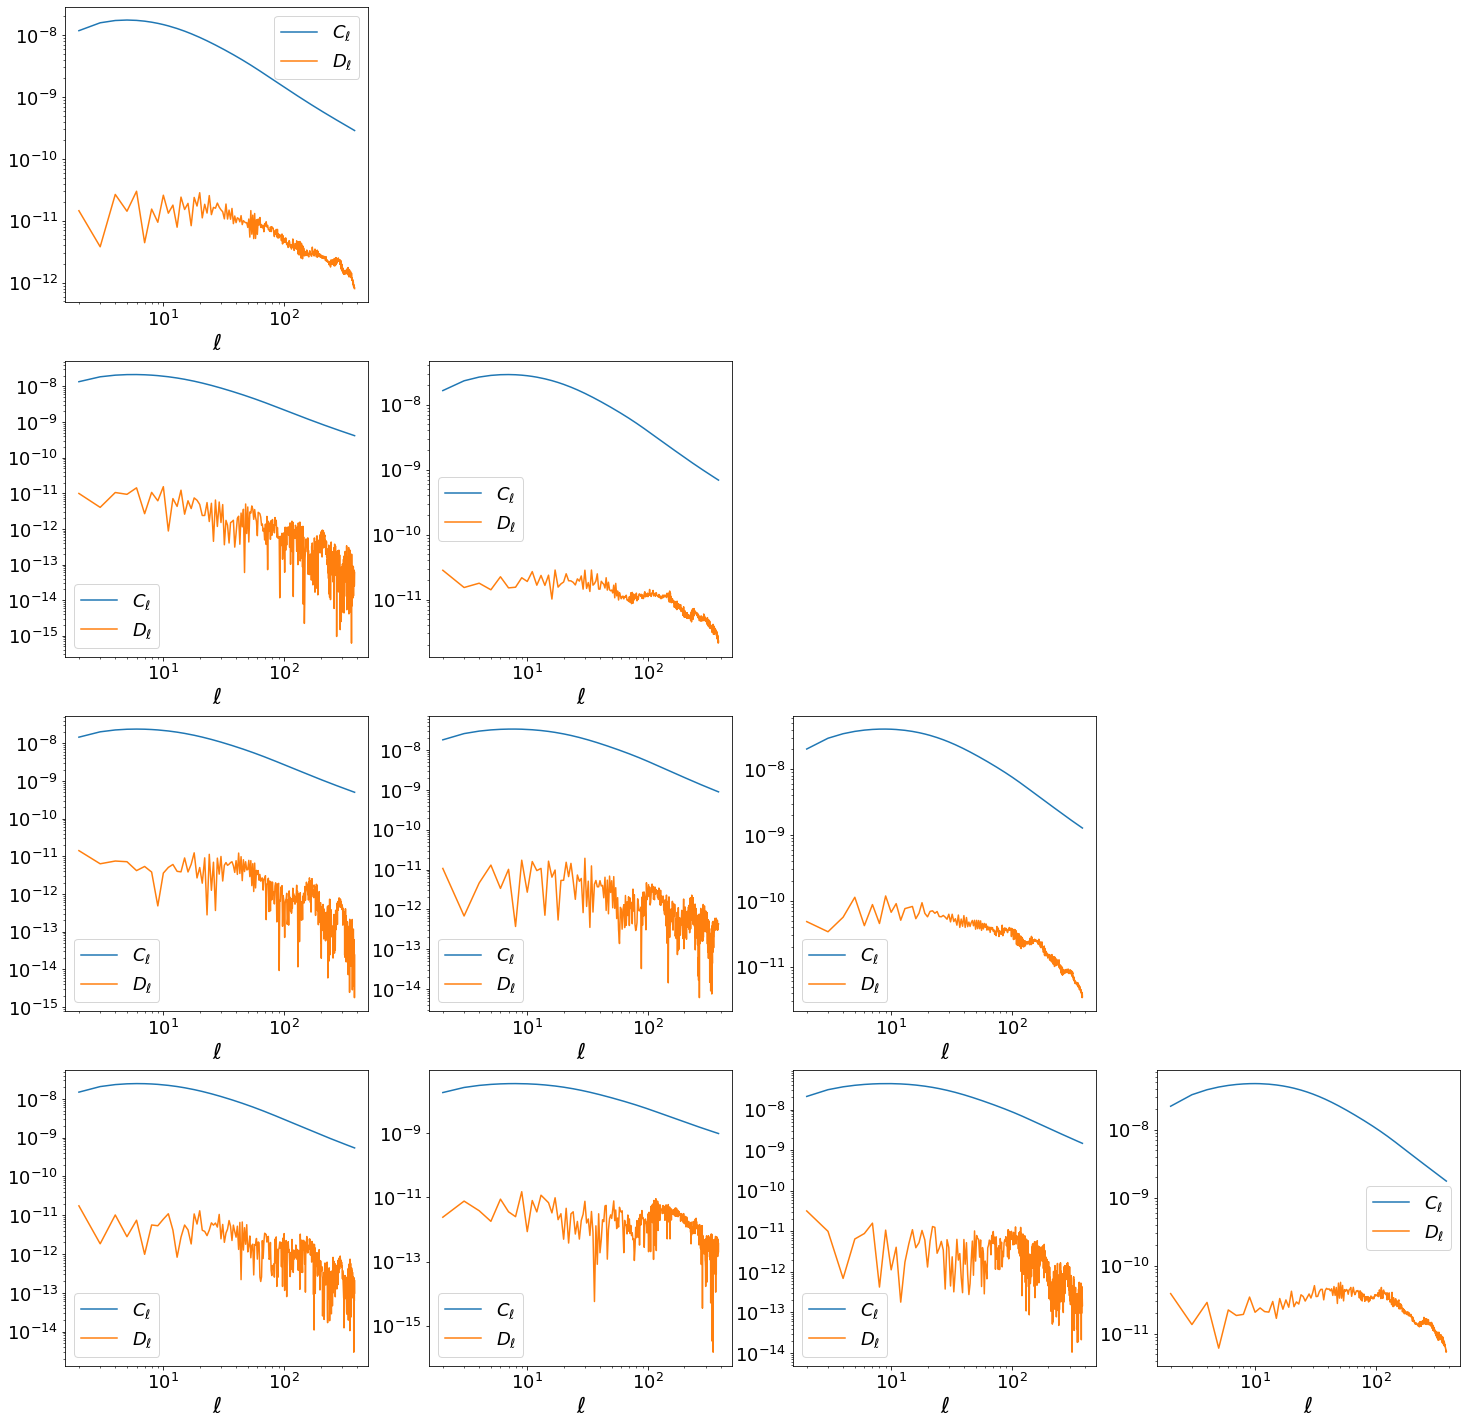

In [20]:
plt.figure(figsize=(25, 25))
n_bins = sim_dict['n_bins']
for i in range(n_bins):
    for j in range(n_bins):
        if j <= i:
            plt.subplot(n_bins, n_bins, i * n_bins + j + 1)
            plt.loglog(ell[2:], cl_ccl[(j, i)][2:], label=r'$C_\ell$')
            plt.loglog(ell[2:], Dl_nmt[(j, i)][2:], label=r'$D_\ell$')
            plt.xlabel(r'$\ell$', fontsize=22)
            plt.xticks(fontsize=18)
            plt.yticks(fontsize=18)
            plt.legend(fontsize=18)

# noise = sigma_e ** 2 / n_eff / f_sky

In [21]:
# HSC coverage is 1400 sq deg.
full_sky = 4 * np.pi * (180 / np.pi) ** 2
f_sky = 1400 / (full_sky)

In [22]:
use_window=True
unit_window=False

do_pseudo_cl=True
do_xi=False

bin_cl=True
bin_xi=True

use_binned_l=False
use_binned_theta=False

store_win=True

In [23]:
shear_zbins=lsst_source_tomo_bins(nbins=sim_dict['n_bins'],use_window=use_window,nside=nside,f_sky=f_sky,unit_win=unit_window)

ns0:  27.0
[0.10002001 0.10082017 0.10162032 ... 2.9981997  2.9989998  2.9998    ] 100 5
source_tomo_bins, zmax 5.0 2.9998 0.59997
Tracer utils has no tracers
skylens will use following default values:  {'yaml_inp_file': None, 'python_inp_file': None, 'l_cl': None, 'Ang_PS': None, 'logger': None, 'tracer_utils': None, 'shear_zbins': None, 'kappa_zbins': None, 'zkernel_func_names': {'shear': 'set_kernel', 'galaxy': 'set_kernel', 'kappa': 'set_kernel'}, 'pk_params': {'non_linear': 1, 'kmax': 30, 'kmin': 0.0003, 'nk': 500, 'scenario': 'dmo', 'pk_func': 'camb_pk_too_many_z', 'halofit_version': 'takahashi'}, 'cosmo_params': {'h': 0.7, 'Omb': 0.046, 'Omd': 0.233, 's8': 0.817, 'Om': 0.279, 'Ase9': 2.1842, 'mnu': 0.06, 'Omk': 0.0, 'tau': 0.06, 'ns': 0.965, 'OmR': 0.0014936944554559178, 'w': -1, 'wa': 0, 'Tcmb': <Quantity 2.7255 K>, 'z_max': 4, 'use_astropy': True, 'Oml': 0.721, 'astropy_cosmo': FlatLambdaCDM(name="Planck18", H0=67.66 km / (Mpc s), Om0=0.30966, Tcmb0=2.7255 K, Neff=3.046, m_nu=

/hildafs/home/andypark/.local/lib/python3.9/site-packages/skylens-0.1-py3.9.egg/skylens/angular_power_spectra.py:33: RuntimeWarning: divide by zero encountered in true_divide


power spectra function:  <bound method Power_Spectra.camb_pk_too_many_z of <skylens.power_spectra.Power_Spectra object at 0x14fb471f7700>>
Win gen: step size 19 384 31.0 10 False True
Window done. Size: 0.0


/hildafs/home/andypark/.local/lib/python3.9/site-packages/skylens-0.1-py3.9.egg/skylens/angular_power_spectra.py:123: RuntimeWarning: divide by zero encountered in true_divide


scatter_dict got empty dictionary
cl_tomo, Win: None
cl graph done
gather_dict got empty dictionary


In [24]:
shear_zbins.keys()

dict_keys(['SN', 0, 1, 2, 3, 'n_bins', 'zmax', 'zp', 'zs', 'pz', 'z_bins', 'zp_sigma', 'zp_bias', 'bias_func'])

In [25]:
shear_zbins[0].keys()

dict_keys(['z', 'dz', 'nz', 'ns', 'W', 'pz', 'pzdz', 'Norm', 'b1', 'bz1', 'AI', 'AI_z', 'mag_fact', 'shear_m_bias', 'lm', 'k_max', 'window_cl0', 'window', 'window_N'])

In [26]:
for i in range(sim_dict['n_bins']):
    sim = sim_dict[i]
    shear_zbins[i]['z'] = sim['z']
    shear_zbins[i]['dz'] = np.gradient(sim['z'])
    shear_zbins[i]['pz'] = sim['dNdz']
    shear_zbins[i]['pzdz'] = sim['dNdz'] * np.gradient(sim['z'])
    shear_zbins[i]['window'] = mask[i]
    shear_zbins[i]['window_N'] = mask[i]

In [27]:
corrs = [corr_ll]
bi=(0,0)
corr=corrs[0]
s=s1_s2s[corr]
if corr==corr_ll:
    s=(2,-2)

In [28]:
#setup parameters
lmax_cl = 3 * nside - 1 #2000
lmin_cl = 0

l0 = np.arange(lmin_cl, lmax_cl)

window_lmax = lmax_cl

lmin_cl_Bins = 10 #lmin_cl+2
lmax_cl_Bins = lmax_cl - 10
Nl_bins = 20

# l_bins=get_l_bins(l_min=lmin_cl_Bins,l_max=lmax_cl_Bins,N_bins=Nl_bins,binning_scheme='log',min_modes=1)#,binning_mode='decreasing')
# l_bins=l_bins[l_bins<=lmax_cl_Bins]
# l_bins0=l_bins*1.
l_bins = np.unique(np.int64(np.logspace(np.log10(lmin_cl_Bins), np.log10(lmax_cl_Bins), Nl_bins+1)))
lb = .5 * (l_bins[1:] + l_bins[:-1])
dl = (l_bins[1:] - l_bins[:-1])
lb_cl = lb * 1.
l_bins_center = lb * 1.
Nl_bins = len(lb)

# l=np.unique(np.int64(np.logspace(np.log10(lmin_cl),np.log10(lmax_cl),Nl_bins*20))) #if we want to use fewer ell
l = l0

In [29]:
Skylens_kwargs=parse_dict(locals())

Skylens_kwargs['do_pseudo_cl']=True
Skylens_kwargs['do_xi']=False
SL_cl0=Skylens(**Skylens_kwargs)

skylens will use following default values:  {'yaml_inp_file': None, 'python_inp_file': None, 'use_defaults': None, 'l_cl': None, 'Ang_PS': None, 'logger': None, 'kappa_zbins': None, 'galaxy_zbins': None, 'zkernel_func_names': {'shear': 'set_kernel', 'galaxy': 'set_kernel', 'kappa': 'set_kernel'}, 'pk_params': {'non_linear': 1, 'kmax': 30, 'kmin': 0.0003, 'nk': 500, 'scenario': 'dmo', 'pk_func': 'camb_pk_too_many_z', 'halofit_version': 'takahashi'}, 'cosmo_params': {'h': 0.7, 'Omb': 0.046, 'Omd': 0.233, 's8': 0.817, 'Om': 0.279, 'Ase9': 2.1842, 'mnu': 0.06, 'Omk': 0.0, 'tau': 0.06, 'ns': 0.965, 'OmR': 0.0014936944554559178, 'w': -1, 'wa': 0, 'Tcmb': <Quantity 2.7255 K>, 'z_max': 4, 'use_astropy': True, 'Oml': 0.721, 'astropy_cosmo': FlatLambdaCDM(name="Planck18", H0=67.66 km / (Mpc s), Om0=0.30966, Tcmb0=2.7255 K, Neff=3.046, m_nu=[0.   0.   0.06] eV, Ob0=0.04897)}, 'WT_kwargs': None, 'WT': None, 'z_PS': None, 'log_z_PS': 2, 'window_l': None, 'Win': None, 'cl_func_names': {('galaxy', 'g

/hildafs/home/andypark/.local/lib/python3.9/site-packages/skylens-0.1-py3.9.egg/skylens/angular_power_spectra.py:33: RuntimeWarning: divide by zero encountered in true_divide


power spectra function:  <bound method Power_Spectra.camb_pk_too_many_z of <skylens.power_spectra.Power_Spectra object at 0x14fb433fe070>>
Win gen: step size 100 383 384.0 1 True True
Win not found, computing now
get_Win, total cl keys:  10
set window_cl: cl0,cl_b done 0.00016546249389648438
set window_cl: cl done 0.03674626350402832 0.016 0.0
set_window_cl done 2.13423490524292
wigner_files: {0: '/hildafs/projects/phy200017p/andypark/Skylens_public/temp/wig3j_l5000_w5000_0_reorder.zarr', 2: '/hildafs/projects/phy200017p/andypark/Skylens_public/temp/wig3j_l2200_w4400_2_reorder.zarr'}
wigner done dict_keys([])
setting windows, coupling matrices  <Client: 'tcp://127.0.0.1:39279' processes=1 threads=1, memory=51.56 GiB>
get_coupling_lm_all_win 200
got wig3j 200
done lm 200 3.418407917022705
get_coupling_lm_all_win 100
got wig3j 100
done lm 100 2.973196029663086
get_coupling_lm_all_win 300
got wig3j 300
done lm 300 3.4022879600524902
done combine lm 10.878565549850464
get_coupling_lm_all_w

In [30]:
clG = SL_cl0.cl_tomo()
cl0 = client.compute(clG['cl_b']).result()
pcl0 = client.compute(clG['stack']).result()

/hildafs/home/andypark/.local/lib/python3.9/site-packages/skylens-0.1-py3.9.egg/skylens/angular_power_spectra.py:123: RuntimeWarning: divide by zero encountered in true_divide


scatter_dict got empty dictionary
cl_tomo, Win: {'cl': {('shear', 'shear'): {(0, 0): <Future: finished, type: dict, key: (0, 0)>, (0, 1): <Future: finished, type: dict, key: (0, 1)>, (1, 0): <Future: finished, type: dict, key: (1, 0)>, (0, 2): <Future: finished, type: dict, key: (0, 2)>, (2, 0): <Future: finished, type: dict, key: (2, 0)>, (0, 3): <Future: finished, type: dict, key: (0, 3)>, (3, 0): <Future: finished, type: dict, key: (3, 0)>, (1, 1): <Future: finished, type: dict, key: (1, 1)>, (1, 2): <Future: finished, type: dict, key: (1, 2)>, (2, 1): <Future: finished, type: dict, key: (2, 1)>, (1, 3): <Future: finished, type: dict, key: (1, 3)>, (3, 1): <Future: finished, type: dict, key: (3, 1)>, (2, 2): <Future: finished, type: dict, key: (2, 2)>, (2, 3): <Future: finished, type: dict, key: (2, 3)>, (3, 2): <Future: finished, type: dict, key: (3, 2)>, (3, 3): <Future: finished, type: dict, key: (3, 3)>}}}
cl graph done
gather_dict got empty dictionary


In [31]:
SL_cl0.gather_data()

gather_dict got empty dictionary


In [32]:
SL_cl0.Win['cl'][corr_ll].keys()

dict_keys([(0, 0), (0, 1), (1, 0), (0, 2), (2, 0), (0, 3), (3, 0), (1, 1), (1, 2), (2, 1), (1, 3), (3, 1), (2, 2), (2, 3), (3, 2), (3, 3)])

In [33]:
cl_sl = dict()
cl_sl_binned = dict()
for i in range(sim_dict['n_bins']):
    for j in range(i, sim_dict['n_bins']):
        M = SL_cl0.Win['cl'][corr_ll][(i, j)]['M']
        pcl_binned = SL_cl0.binning.bin_1d(Dl_nmt[(i, j)][lmin_cl:-1], bin_utils=SL_cl0.cl_bin_utils)
        cl_binned = SL_cl0.binning.bin_1d(cl_ccl[(i, j)][lmin_cl:-1], bin_utils=SL_cl0.cl_bin_utils)
        wt0 = 1. / cl_ccl[(i, j)][lmin_cl:-1]
        wt0[:2] = 0
        M_binned = SL_cl0.binning.bin_2d_coupling(M=M, wt0=wt0, 
                                                 wt_b=cl_binned, bin_utils=SL_cl0.cl_bin_utils)
        cl_sl[(i, j)] = Dl_nmt[(i, j)][lmin_cl:-1] @ np.linalg.pinv(M)
        cl_sl_binned[(i, j)] = pcl_binned @ np.linalg.pinv(M_binned)

/tmp/ipykernel_340400/839116116.py:8: RuntimeWarning: divide by zero encountered in true_divide
  wt0 = 1. / cl_ccl[(i, j)][lmin_cl:-1]


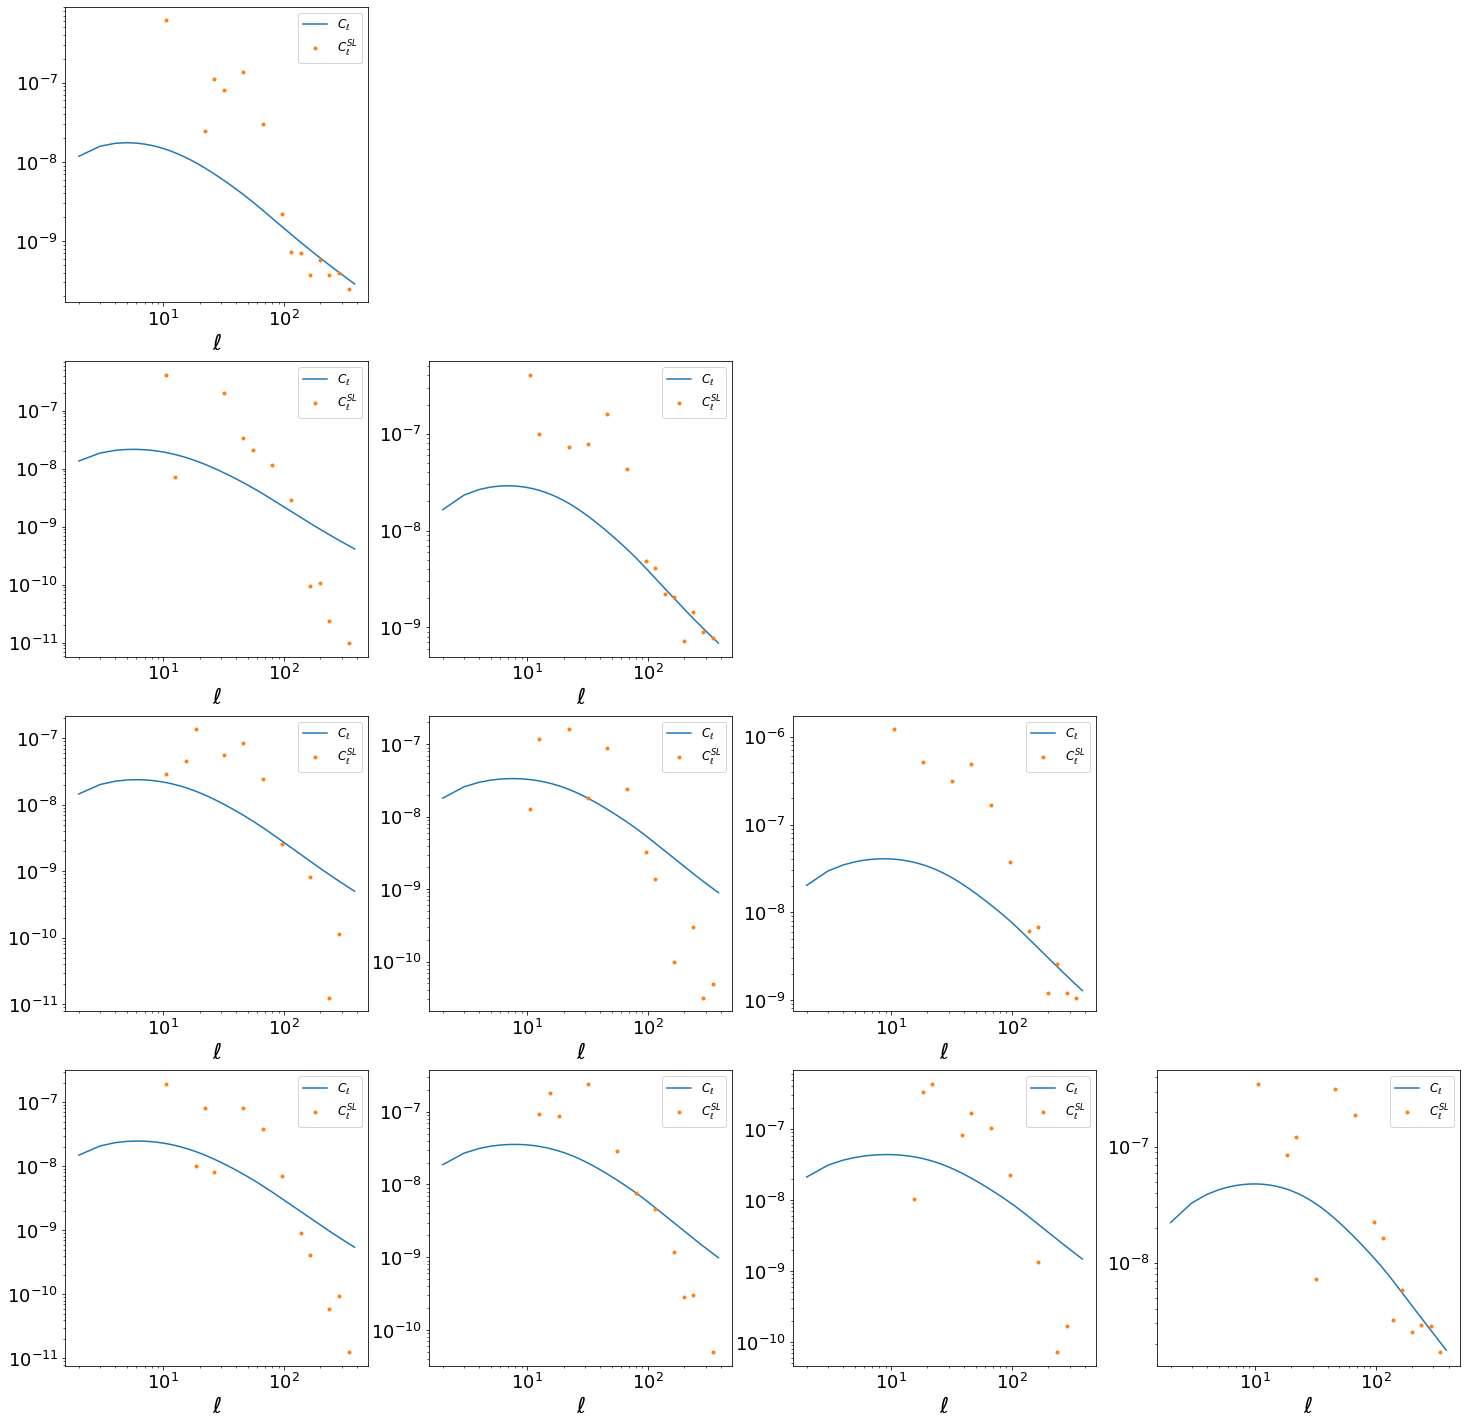

In [34]:
bc = 0.5 * (SL_cl0.l_bins[1:] + SL_cl0.l_bins[:-1])
plt.figure(figsize=(25, 25))
n_bins = sim_dict['n_bins']
for i in range(n_bins):
    for j in range(n_bins):
        if j <= i:
            plt.subplot(n_bins, n_bins, i * n_bins + j + 1)
            plt.loglog(ell[2:], cl_ccl[(j, i)][2:], label=r'$C_\ell$')
            #plt.loglog(ell[2:], Dl_nmt[(j, i)][2:], label=r'$D_\ell$')
            #plt.loglog(ell[2:-1], np.abs(cl_sl[(j, i)][2:]), label=r'$C_\ell^{SL}$')
            plt.loglog(bc, cl_sl_binned[(j, i)], '.', label=r'$C_\ell^{SL}$')
            plt.xlabel(r'$\ell$', fontsize=22)
            plt.xticks(fontsize=18)
            plt.yticks(fontsize=18)
            plt.legend(fontsize=12)